In [1]:
import numpy as np
import scipy.stats as stats
from scipy.special import gammaln
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

While it is possible to compute jacobians for each transformation by composing jacobians of each "sub-transformation", as they do in tensorflow probability (softclip bijector is a good example), it's also possible to find a closed form explicitely. 

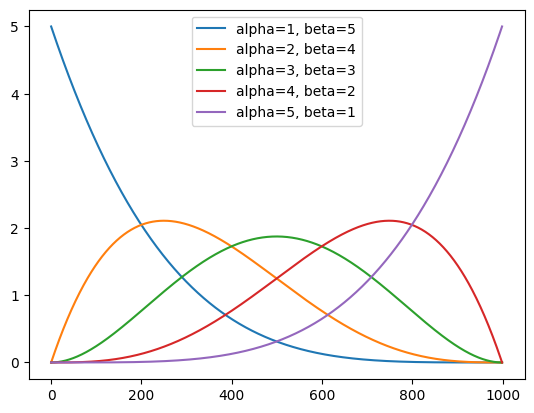

In [25]:


# ----------------------------------------
# Softplus
# ----------------------------------------
def softplus(x):
    return np.log(1 + np.exp(x))

def inverse_softplus(x):
    return np.log(np.exp(x) - 1)

def softplus_derivative(x):
    expx = np.exp(x)
    return expx / (1 + expx)

# ----------------------------------------
# Softclip
# ----------------------------------------
def softclip(x, low=0.0, high=1.0):
    hl = high - low
    return - softplus(hl - softplus(x - low)) * hl / softplus(hl) + high

def inverse_softclip(y, low=0.0, high=1.0):
    return np.log(-np.exp(low) + np.exp(high) / (np.exp(((high - y) * np.log(np.exp(high) * np.exp(-low) + 1) / (high - low))) - 1))

def softclip_derivative(x, low=0.0, high=1.0):
    hl = high - low
    numerator = hl * np.exp(high - 2*low + x)
    denominator = (np.exp(-low + x) + 1) * (np.exp(hl) + np.exp(-low + x) + 1) * np.log(np.exp(hl) + 1)
    return numerator / denominator

# ----------------------------------------
# Beta distribution (needed for Bernstein bijector)
# ----------------------------------------
def beta_function(alpha, beta):
    return np.exp(gammaln(alpha) + gammaln(beta) - gammaln(alpha + beta))

def beta_pdf(x, alpha, beta):
    alpha, beta = map(np.asarray, (alpha, beta))
    B = beta_function(alpha, beta)
    return x**(alpha - 1) * (1 - x)**(beta - 1) / B

def beta_pdf_derivative(x, alpha, beta):
    alpha, beta = map(np.asarray, (alpha, beta))
    B = beta_function(alpha, beta)
    return ((alpha - 1) * x**(alpha - 2) * (1 - x)**(beta - 1) - (beta - 1) * x**(alpha - 1) * (1 - x)**(beta - 2)) / B


x = np.linspace(0, 1, 1000)
order = 5
alpha = np.arange(1, order + 1)
beta = alpha[::-1]

for i in range(order):
    plt.plot(stats.beta.pdf(x, alpha[i], beta[i]), label=f"alpha={alpha[i]}, beta={beta[i]}")

plt.legend()

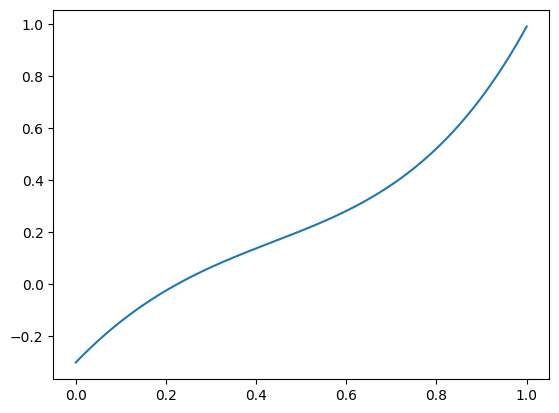

In [3]:
x = np.linspace(0 + 1e-6, 1 - 1e-6, 1000)
thetas = np.array([-0.3, 0.15, 0.2, 0.2, 0.99])
bx = beta_pdf(x[:, None], alpha, beta)
z = np.mean(bx * thetas, axis=1)

plt.plot(x, z)

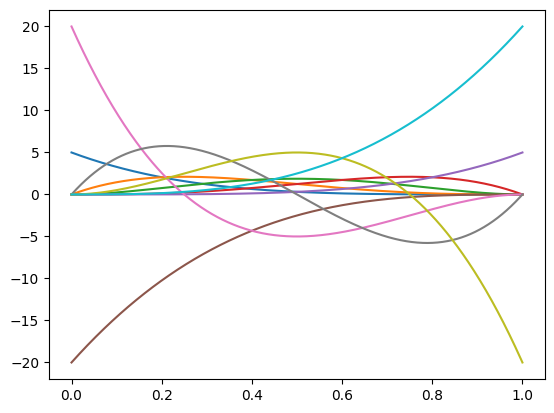

In [4]:
plt.plot(x[:,None], beta_pdf(x[:,None], alpha, beta))
plt.plot(x[:,None], beta_pdf_derivative(x[:,None], alpha, beta))

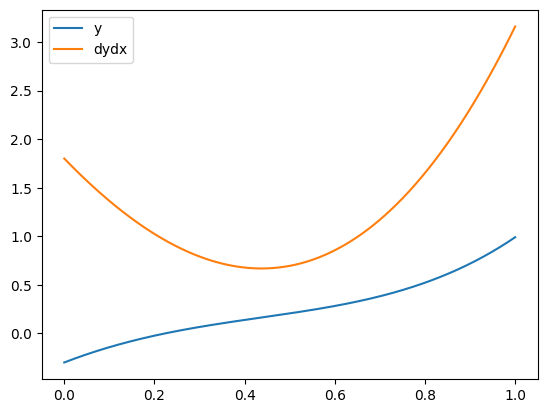

In [5]:
bx = beta_pdf(x[:,None], alpha, beta)
dbdx = beta_pdf_derivative(x[:,None], alpha, beta)
plt.plot(x, np.mean(bx * thetas, axis=-1), label="y")
plt.plot(x, np.mean(dbdx * thetas, axis=-1), label="dydx")
plt.legend()

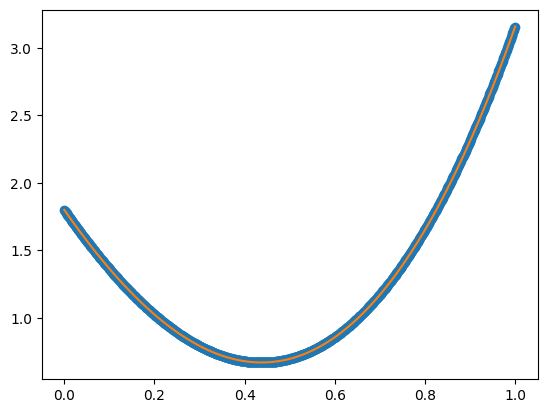

In [6]:
dydx_numerical = np.diff(z) / np.diff(x)
plt.plot(x[:-1], dydx_numerical, marker="o", linestyle="None")
plt.plot(x, np.mean(dbdx * thetas, axis=-1), label="dydx")

In [7]:
def constrain_thetas(thetas):
    return np.cumsum(softplus(thetas), axis=None)

constrain_thetas([-1.1, -0.1, 0.3, -0.1, 0.2])

array([0.28733533, 0.93173199, 1.78608723, 2.43048389, 3.22862276])

In [140]:
class BernsteinBijector:
    """A Bernstein polynomial bijector.
    
    The Bernstein polynomial is defined as:
    
    B(x) = sum_{i=0}^{n} theta_i * B_{i,n}(x)
    
    where B_{i,n}(x) is the i-th Bernstein basis polynomial of degree n.
    """

    def __init__(self, thetas):
        """Initializes the bijector.

        Args:
            thetas: A list of coefficients for the Bernstein polynomial.
        """
        self.thetas = np.asarray(thetas)
        self.order = len(thetas)
        self.alpha = np.arange(1, self.order + 1)
        self.beta = self.alpha[::-1]

    def forward(self, x):
        """Computes y = f(x)."""
        x = np.clip(x, 1e-7, 1 - 1e-7)
        bx = beta_pdf(x[...,None], self.alpha, self.beta)
        return np.einsum("b,...b->...", self.thetas, bx)
    
    def inverse(self, y):
        """Computes x = f^{-1}(y)."""
        batch_shape = self.thetas.shape[:-1]
        n_points = 100
        clip = 1e-7
        x_fit = np.linspace(clip, 1 - clip, n_points)[:,None] * np.ones(
            (1,) + batch_shape
        )
        y_fit = self.forward(x_fit)

        def inp(y, y_fit, x_fit):
            return np.interp(y.ravel(), y_fit.ravel(), x_fit.ravel())

        return inp(y, y_fit, x_fit).reshape(batch_shape + y.shape)
    
    def forward_log_det_jacobian(self, x):
        """Computes log|det J(f)(x)|."""
        x = np.clip(x, 1e-7, 1 - 1e-7)
        return np.log(np.abs(beta_pdf_derivative(x, self.alpha, self.beta) @ self.thetas))
    
    def inverse_log_det_jacobian(self, y):
        """Computes log|det J(f^{-1})(y)|."""
        return -self.forward_log_det_jacobian(self.inverse(y))
    
    def forward_and_log_det(self, x):
        """Computes f(x) and log|det J(f)(x)|."""
        return self.forward(x), self.forward_log_det_jacobian(x)
    


class Softclip:
    """A softclip bijector.
    
    The softclip function is defined as:
    
    f(x) = - softplus(high - softplus(x - low)) * (high - low) / softplus(high) + high
    
    where softplus(x) = log(1 + exp(x)).
    """

    def __init__(self, low=0.0, high=1.0):
        """Initializes the bijector.

        Args:
            low: The lower bound of the softclip function.
            high: The upper bound of the softclip function.
        """
        self.low = low
        self.high = high

    def forward(self, x):
        return softclip(x, self.low, self.high)
    
    def inverse(self, y):
        return inverse_softclip(y, self.low, self.high)
    
    def forward_log_det_jacobian(self, x):
        return np.log(np.abs(softclip_derivative(x, self.low, self.high)))
    
    def inverse_log_det_jacobian(self, y):
        return -np.log(np.abs(softclip_derivative(y, self.low, self.high)))
    
    def forward_and_log_det(self, x):
        return self.forward(x), self.forward_log_det_jacobian(x)
    

class Softplus:
    """A softplus bijector.

    The softplus function is defined as:

    f(x) = log(1 + exp(x)).

    It's a parameterer-free bijector, so it doesn't have any parameters.
    """

    def forward(self, x):
        return softplus(x)
    
    def inverse(self, y):
        return inverse_softplus(y)
    
    def forward_log_det_jacobian(self, x):
        return np.log(softplus_derivative(x))
    
    def inverse_log_det_jacobian(self, y):
        return -np.log(softplus_derivative(y))
    
    def forward_and_log_det(self, x):
        return self.forward(x), self.forward_log_det_jacobian(x)
    

class Scale:

    def __init__(self, scale):
        self.scale = scale

    def forward(self, x):
        return x * self.scale
    
    def inverse(self, y):
        return y / self.scale
    
    def forward_log_det_jacobian(self, x):
        return np.log(np.abs(self.scale))
    
    def inverse_log_det_jacobian(self, y):
        return -np.log(np.abs(self.scale))
    
    def forward_and_log_det(self, x):
        return self.forward(x), self.forward_log_det_jacobian(x)
    

class Shift:

    def __init__(self, shift):
        self.shift = shift

    def forward(self, x):
        return x + self.shift
    
    def inverse(self, y):
        return y - self.shift
    
    def forward_log_det_jacobian(self, x):
        return np.zeros_like(x)
    
    def inverse_log_det_jacobian(self, y):
        return np.zeros_like(y)
    
    def forward_and_log_det(self, x):
        return self.forward(x), self.forward_log_det_jacobian(x)
    

class Chain:
    """A chain of bijectors.
    
    This class represents a chain of bijectors, which is itself a bijector.
    
    Bijectors are applied in reverse order: for two bijectors f and g, if the chain
    is [f, g], then the forward transformation is f(g(x)), not 'f and then g', therefore
    g is applied first and f is applied second.

    Example:
    >>> x = np.linspace(-1, 1, 1000)
    >>> f = Scale(2.0)
    >>> g = Shift(1.0)
    >>> chain = Chain([f, g])
    >>> y = chain.forward(x)  # equivalent to f(g(x))

    """

    def __init__(self, bijectors):
        self.bijectors = bijectors

    def forward(self, x):
        y = x
        for bijector in self.bijectors[::-1]:
            y = bijector.forward(y)
        return y
    
    def inverse(self, y):
        x = y
        for bijector in self.bijectors:
            x = bijector.inverse(x)
        return x
    
    def forward_log_det_jacobian(self, x):
        fldj = np.zeros_like(x)
        for bijector in self.bijectors:
            fldj += bijector.forward_log_det_jacobian(x)
            x = bijector.forward(x)
        return fldj
    
    def inverse_log_det_jacobian(self, y):
        ildj = np.zeros_like(y)
        for bijector in self.bijectors[::-1]:
            ildj += bijector.inverse_log_det_jacobian(y)
            y = bijector.inverse(y)
        return ildj
    
    def forward_and_log_det(self, x):
        y = x
        fldj = np.zeros_like(x)
        for bijector in self.bijectors:
            y, fldj_ = bijector.forward_and_log_det(y)
            fldj += fldj_
        return y, fldj

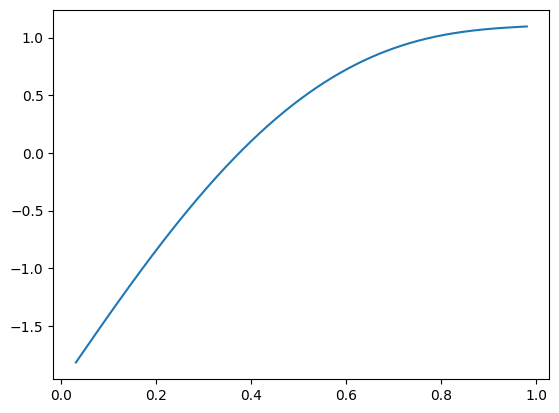

In [141]:
bj = BernsteinBijector(thetas)
# x = np.linspace(0 + 1e-6, 1 - 1e-6, 1000)
x = softclip(np.sort(rng.standard_normal(5000) + 0.5))
y = bj.forward(x)
plt.plot(x, y)

(array([  5.,  12.,  11.,  33.,  42.,  54.,  60.,  72.,  91.,  90., 106.,
        114., 126., 145., 149., 151., 166., 173., 191., 193., 216., 235.,
        234., 283., 273., 305., 331., 369., 383., 387.]),
 array([-1.81775905, -1.72063357, -1.62350809, -1.52638261, -1.42925713,
        -1.33213165, -1.23500617, -1.13788069, -1.04075521, -0.94362973,
        -0.84650425, -0.74937877, -0.65225329, -0.5551278 , -0.45800232,
        -0.36087684, -0.26375136, -0.16662588, -0.0695004 ,  0.02762508,
         0.12475056,  0.22187604,  0.31900152,  0.416127  ,  0.51325248,
         0.61037796,  0.70750344,  0.80462892,  0.9017544 ,  0.99887989,
         1.09600537]),
 <BarContainer object of 30 artists>)

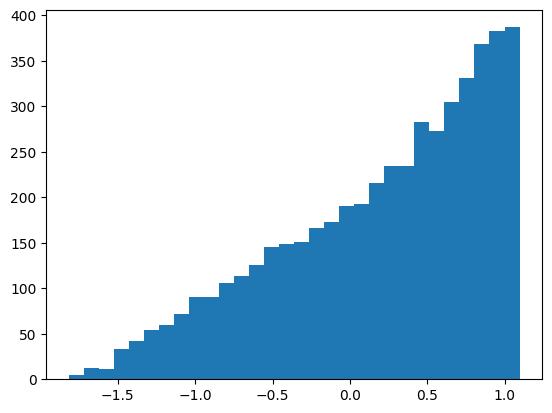

In [142]:
plt.hist(y, bins=30)

(array([ 17.,  39.,  86., 126., 141., 183., 209., 235., 229., 250., 257.,
        249., 280., 257., 274., 269., 251., 242., 220., 201., 208., 186.,
        132., 112., 122.,  89.,  65.,  43.,  21.,   7.]),
 array([0.03040024, 0.06206183, 0.09372343, 0.12538502, 0.15704662,
        0.18870821, 0.22036981, 0.2520314 , 0.283693  , 0.31535459,
        0.34701619, 0.37867779, 0.41033938, 0.44200098, 0.47366257,
        0.50532417, 0.53698576, 0.56864736, 0.60030895, 0.63197055,
        0.66363214, 0.69529374, 0.72695533, 0.75861693, 0.79027852,
        0.82194012, 0.85360172, 0.88526331, 0.91692491, 0.9485865 ,
        0.9802481 ]),
 <BarContainer object of 30 artists>)

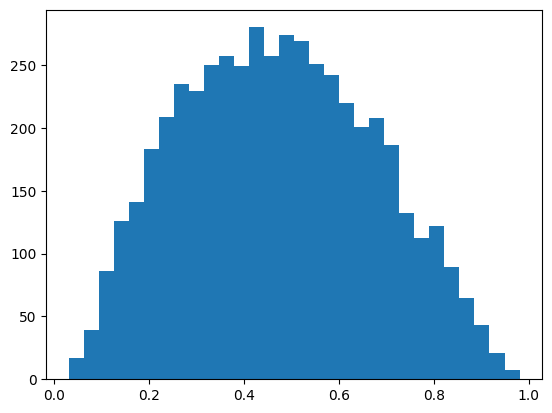

In [143]:
plt.hist(x, bins=30)

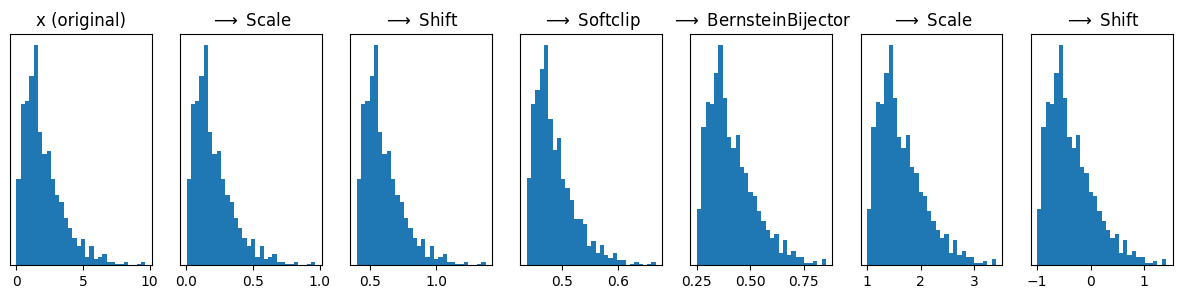

In [144]:
thetas = [-0.4, -0.1, 0.2, 0.21, 0.22]

bj = Chain(
    [Scale(0.1), Shift(0.4), Softclip(), BernsteinBijector(thetas), Scale(4), Shift(-2)],
)

fig, axs = plt.subplots(1, 7, figsize=(15, 3))
x_ = stats.gamma(2).rvs(1000)
axs[0].hist(x_, bins=30)
axs[0].set_title("x (original)")
axs[0].yaxis.set_visible(False)

for i, bj_ in enumerate(bj.bijectors):
    x_ = bj_.forward(x_)
    axs[i+1].hist(x_, bins=30, density=True)
    axs[i+1].set_title(rf"$\longrightarrow$ {bj_.__class__.__name__}")
    axs[i+1].yaxis.set_visible(False)

In [201]:
# starting from a normal distribution with mean 1.5 and std 0.3, this bijector 
# should transform it into a normal distribution with mean 0 and std
# (x + shift ) * scale 

bj = Chain(
    [Scale(1/0.3), Shift(-1.5)], # this means Scale(Shift(x)), not "Scale and then Shift"
)

x = 0.9

# these two should be the same
print(stats.norm.logpdf(bj.forward(x)) + bj.forward_log_det_jacobian(x))
print(stats.norm.logpdf(x, loc=1.5, scale=0.3))

-1.7149657288787368
-1.7149657288787368


(array([  3.,   0.,   5.,   4.,   8.,  12.,  17.,  22.,  25.,  42.,  60.,
         67.,  72.,  88., 109.,  82.,  77.,  75.,  65.,  51.,  34.,  32.,
         15.,  12.,  12.,   5.,   1.,   4.,   0.,   1.]),
 array([0.51460521, 0.58264268, 0.65068016, 0.71871763, 0.7867551 ,
        0.85479257, 0.92283004, 0.99086752, 1.05890499, 1.12694246,
        1.19497993, 1.26301741, 1.33105488, 1.39909235, 1.46712982,
        1.5351673 , 1.60320477, 1.67124224, 1.73927971, 1.80731718,
        1.87535466, 1.94339213, 2.0114296 , 2.07946707, 2.14750455,
        2.21554202, 2.28357949, 2.35161696, 2.41965444, 2.48769191,
        2.55572938]),
 <BarContainer object of 30 artists>)

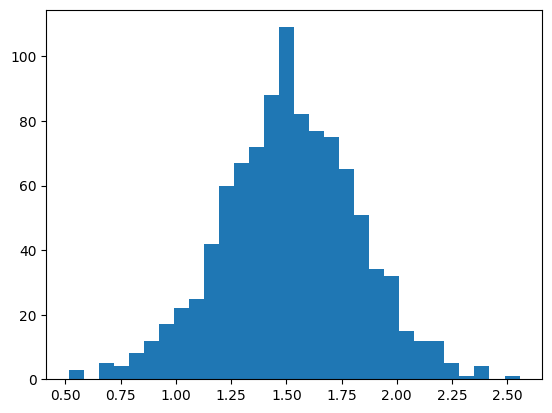

In [202]:
plt.hist(bj.inverse(rng.standard_normal(1000)), bins=30)

In [ ]:
def transform(params, x):

    # shift and scale
    x = (x + params[0]) * softplus(params[1])